# CIS680: Project 3: SOLO and FPN (Instance Segmentation)
### Due:
* Part (a) Oct. 17 at 11:59 p.m.
* Part (b) Oct. 24 at 11:59 p.m.

### Instructions:
* This is a group assignment with one submission per group. It is expected that each member of the group will contribute to solving each question. Be sure to specify your teammates when you submit to Gradescope! Collaborating with other groups is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python.
* You may include any code used in previous projects.
* You should expect that a complete training session should last about 6 hours, so you should start part (b) as early as you can!
* To save on compute time, we debugging locally and using colab to train.

## Code Structure
In this assignment, we are only providing the barest templates for your code structure. If you prefer, you can write and debug most of the components in a regular python and only use Jupyter to train. In this case, you might have several files that you import into this notebook, e.g.
* `dataset.py`
* `model.py`
* `train.py`
* `inference.py`

This is shown below. All files should be included in your submission.

In [ ]:
try:
    import dataset
    import model
    import train
    import inference
except ModuleNotFoundError:
    pass

In [1]:
from google.colab import drive
import os

drive.mount('/content/gdrive')
os.chdir('gdrive/My Drive/CIS680_2021/HW3')

!pip install pytorch_lightning

Mounted at /content/gdrive
     |████████████████████████████████| 925 kB 13.3 MB/s 
     |████████████████████████████████| 596 kB 45.0 MB/s 
     |████████████████████████████████| 282 kB 18.1 MB/s 
     |████████████████████████████████| 125 kB 52.3 MB/s 
     |████████████████████████████████| 829 kB 38.1 MB/s 
     |████████████████████████████████| 1.3 MB 40.5 MB/s 
     |████████████████████████████████| 271 kB 51.9 MB/s 
     |████████████████████████████████| 160 kB 49.6 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=738227b9d484f7a95aca2da4d4c20f353c74e5e0ecb80d072e80ba0ffc67e8f3
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found existing installation: future 0.16

In [2]:
import numpy as np
import h5py

with h5py.File('hw3_mycocodata_img_comp_zlib.h5', 'r') as f:
  images = f['data'][()]

with h5py.File('hw3_mycocodata_mask_comp_zlib.h5', 'r') as f:
  masks = f['data'][()]

labels = np.load('hw3_mycocodata_labels_comp_zlib.npy', allow_pickle=True)
bounding_boxes = np.load('hw3_mycocodata_bboxes_comp_zlib.npy', allow_pickle=True)

In [3]:
import pytorch_lightning as pl
import torch
from torch import nn
import torchvision

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
seed = 17
torch.manual_seed(seed);

In [4]:
len_labels = [len(lab) for lab in labels]
cumsum = np.cumsum(len_labels)

mask_list = []
for i in range(len(len_labels)):
  start_idx = 0 if i == 0 else cumsum[i-1]
  mask_list.append(masks[start_idx:cumsum[i]])

masks = np.array(mask_list, dtype=object)
del mask_list

## Overview

Instance segmentation can be thought of as a combination of object detection and semantic segmentation, the former of which you already explored in the previous project. A visulization of this relationship can be seen in fig. 1.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig1.png" width=500/></div>
<center>Figure 1: An overview of instance segmentation.</center>  

In this project, you are tasked with implementing an instance segmentation framework know as SOLO (Segmenting Object by LOcations). In a similar manner to YOLO, SOLO produces mask predictions on a dense grid. This means that, unlike many other segmenation frameworks (e.g. Mask-RCNN), SOLO directly predicts the segmentation mask without proposing bounding box locations. An visual summary of SOLO can be seen in fig. 2 and 3.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig2.png" width=200/></div>
<center>Figure 2: SOLO.</center>  

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig3.png" width=600/></div>
<center>Figure 3: SOLO branches.</center>

These dense predictions are produced at several different scales using a Feature Pyramid Network (FPN). Using the last few layers of the backbone, we pass the higher level features from the deeper layers back up to larger features scales using lateral connections, shown in fig. 4. The integration of the FPN into your network will be the primary focus of this project.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig4.png" width=300/></div>
<center>Figure 4: SOLO branches.</center>

## Part A

### Dataset
#### Dataset Structure
The dataset used in this project contains three classes across 3265 images: vehicles, people, and animals. The dataset contains the following elements:

* A numpy array of images ($3 \times 300 \times 400$).
* A numpy array of masks ($300 \times 400$).
* A list of ground truth labels by image.
* A list of bounding boxes by image.

Note that the mask array is flattened; to determine which masks belong to which image, count the number of labels associated with that image. For example, if the first few images have 3, 2, and 4 labels, masks 0-2 would belong to image 1, masks 3-4 would belong to image 2, etc. The masks are ordered correctly to allow for this. You can find the dataset set here: https://drive.google.com/drive/folders/1eP7FtPaWfJ5zLdcsZYl6eyn5EYixkFn8

#### Loading and Batching
You should apply the following transformations to each image:
* Normalize pixel values to $[0,1]$.
* Rescale the image to $800 \times 1066$.
* Normalize each channel with means $[0.485, 0.456, 0.406]$ and standard deviations $[0.229, 0.224, 0.225]$.
* Zero pad the iamge to $800 \times 1088$.

Since each image will have a different number of objects, you will have to write your own collation function to properly batch the images. An example collate_fn is shown below, along with expected output dimensions.

In [5]:
from torch.utils.data import Dataset
from torchvision import transforms

class SOLODataset(Dataset):
  def __init__(self, images, labels, masks, bounding_boxes, transform=None, target_transform=None):
    self.images = images
    self.labels = labels
    self.masks = masks
    self.bounding_boxes = bounding_boxes
    self.transform = transform
    self.target_transform = target_transform
  
  def __len__(self):
    return self.images.shape[0]
  
  def __getitem__(self, idx):
    image = self.images[idx]
    label = self.labels[idx]
    mask = self.masks[idx]
    bbox = self.bounding_boxes[idx]
    if self.transform:
      image = np.transpose(image, axes=(1, 2, 0))
      image = self.transform(image / 255)
    if self.target_transform:
      mask = torch.cat([self.target_transform(m.astype(np.int)) for m in mask])
    return image, label, mask, bbox
    
img_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((800, 1066)), transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225)), transforms.Pad((11,0))])
mask_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((800, 1066)), transforms.Pad((11, 0))])
train_dataset = SOLODataset(images[:2540], labels[:2540], masks[:2540], bounding_boxes[:2540], transform=img_transform, target_transform=mask_transform)
val_dataset = SOLODataset(images[2540:], labels[2540:], masks[2540:], bounding_boxes[2540:], transform=img_transform, target_transform=mask_transform)

In [6]:
# images:         (batch_size, 3, 800, 1088)
# labels:         list with len: batch_size, each (n_obj,)
# masks:          list with len: batch_size, each (n_obj, 800,1088)
# bounding_boxes: list with len: batch_size, each (n_obj, 4)
def collate_fn(batch):
    images, labels, masks, bounding_boxes = list(zip(*batch))
    return torch.stack(images), labels, masks, bounding_boxes

#### Visualization
In order to validate that you are loading the dataset correct, you should plot at least five example images that include the mask, annotations, and bounding boxes. Examples of such images are shown in fig. 5 and 6. Make sure that the color for each class is consistent!

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig5.png" width=500/></div>
<center>Figure 5: Example visualization.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig6.png" width=500/></div>
<center>Figure 6: Example visualization.</center>

Class legend: Cat=Blue, Vehicle=Red, Person=Green


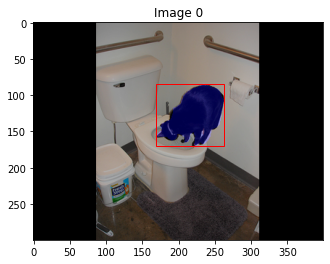

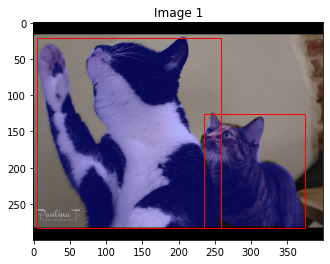

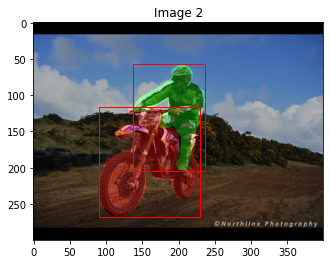

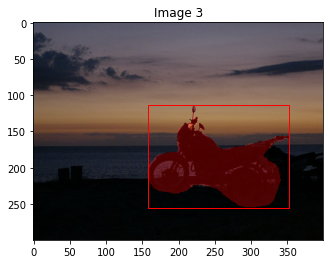

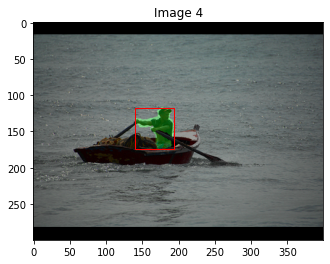

In [7]:
# RUN THIS CELL TO VISUALIZE INITIAL DATASET IMAGES AND LABELS (BOUNDING BOXES AND MASKS)
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

print("Class legend: Cat=Blue, Vehicle=Red, Person=Green")

for i, label_idx in enumerate([0, 3, 5, 10, 25]):
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  img = np.transpose(images[label_idx], axes=(1, 2, 0))
  ax.imshow(img)
  bbox = bounding_boxes[label_idx]
  mask = masks[label_idx]
  lab = labels[label_idx]
  mask_to_display = np.zeros((300, 400, 3))
  for j in range(bbox.shape[0]):
    w = bbox[j, 2]-bbox[j,0]
    h = bbox[j,3]-bbox[j,1]
    rect = Rectangle((bbox[j,0], bbox[j,1]), w, h, edgecolor='r', facecolor=None, fill=False)
    ax.add_patch(rect)
    mask_obj = mask[j,:]
    lab_obj = lab[j]
    idx1, idx2 = np.nonzero(mask_obj)
    mask_to_display[idx1,idx2,lab_obj-1] = 1
  ax.imshow(mask_to_display, alpha=0.3)
  ax.set_title("Image " + str(i))
    

plt.show()

### Model
#### Architecture
The model architecture is summarized in fig. 7 and tables 1 and 2.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig7.png" width=500/></div>
<center>Figure 7: SOLO branch structure.</center>
<br>
<center>Table 1: Category branch structure.</center>

| Layer | Hyperparameters |
| :--- | :--- |
| conv1 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv2 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv3 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv4 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv5 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv6 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv7 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv_out | Kernel size $= 3\times3\times(C-1)$, stride $= 1$, pad $= 1$, bias $= \text{True}$. <br> Followed by Sigmoid layer. Note $C = 4$ here (number of classes + background). |

<br>
<center>Table 2: Mask branch structure.</center>

| Layer | Hyperparameters |
| :--- | :--- |
| conv1 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Two additional input channels are described in the "Forward" section. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv2 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv3 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv4 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv5 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv6 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv7 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv_out | Kernel size $= 1\times1\times(\text{num_grid})^2$, stride $= 1$, pad $= 1$, bias $= \text{True}$. <br> Followed by Sigmoid layer. Note that $\text{num_grid}$ is different for each layer of the FPN. |

We will be using a pretrained backbone (which includes an FPN), so you will not have to implement those components. A template for the network with along with default parameters is shown below.

#### Feature Pyramid
The feature pyramid extracted below has strides $[4,8,16,32,64]$ over the original image. To match the SOLO paper, this should be interpolated to have strides $[8,8,16,32,32]$.

#### Target Assignment
Some notes about generating the ground truth targets:
* The FPN levels can be though of as different grid sizes cut through the image.
* You assign each target to a certain FPN level if $\sqrt{wh}$ from the bounding box falls within the `scale_range` associated with that level. Note that these overlap, so you may assign the same target to multiple levels.
* A grid cell should be considered as predicting an object if that grid cell falls into the "centre region" of the object.
 * The centre region of an object is its bounding box scaled by `epsilon`.
 * Each grid cell can predict at most one object, but each object can be predicted by more than one grid cell.
 
#### Target Visualization
You should produce visualizations such as fig. 8 and 9 to validate your target assignments.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig8.png" width=500/></div>
<center>Figure 8: Target assignment example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig9.png" width=500/></div>
<center>Figure 9: Target assignment example.</center>

In [8]:
import pytorch_lightning as pl
import math
from torch.nn import functional as F

class CategoryBranch(nn.Module):
  def __init__(self):
    super().__init__()
    self.cat_convs = nn.ModuleList()
    self.gns = nn.ModuleList()
    for i in range(7):
      self.cat_convs.append(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False))
      self.gns.append(nn.GroupNorm(num_groups=32, num_channels=256))
    self.relu = nn.ReLU()
    self.conv_out = nn.Conv2d(256, 3, kernel_size=3, stride=1, padding=1, bias=True)
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, x):
    out = x
    for i in range(7):
      out = self.cat_convs[i](out)
      out = self.gns[i](out)
      out = self.relu(out)
    out = self.conv_out(out)
    out = self.sigmoid(out)

    return out

class MaskBranch(nn.Module):
  def __init__(self, num_grids):
    super().__init__()
    self.mask_convs = nn.ModuleList()
    self.mask_gns = nn.ModuleList()
    self.mask_convs.append(nn.Conv2d(258, 256, kernel_size=3, stride=1, padding=1, bias=False))
    self.mask_gns.append(nn.GroupNorm(num_groups=32, num_channels=256))
    for i in range(1, 7):
      self.mask_convs.append(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False))
      self.mask_gns.append(nn.GroupNorm(num_groups=32, num_channels=256))
    self.relu = nn.ReLU()
    self.conv_outs = nn.ModuleList()
    for n in num_grids:
      self.conv_outs.append(nn.Conv2d(256, n**2, kernel_size=1, stride=1, padding=1, bias=True))
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, x, fpn_idx):
    out = x
    for i in range(7):
      out = self.mask_convs[i](out)
      out = self.mask_gns[i](out)
      out = self.relu(out)
    out = self.conv_outs[fpn_idx](out)
    out = self.sigmoid(out)

    return out

class SOLO(pl.LightningModule):
    _default_cfg = {
        'num_classes': 4,
        'in_channels': 256,
        'seg_feat_channels': 256,
        'stacked_convs': 7,
        'strides': [8, 8, 16, 32, 32],
        'scale_ranges': [(1, 96), (48, 192), (96, 384), (192, 768), (384, 2048)],
        'epsilon': 0.2,
        'num_grids': [40, 36, 24, 16, 12],
        'mask_loss_cfg': dict(weight=3),
        'cate_loss_cfg': dict(gamma=2, alpha=0.25, weight=1),
        'postprocess_cfg': dict(cate_thresh=0.2, mask_thresh=0.5, pre_NMS_num=50, final_thresh=0.2, IoU_thresh=0.5),
        'input_image_size': (800, 1088)
    }
    
    def __init__(self, **kwargs):
        super().__init__()
        for k, v in {**self._default_cfg, **kwargs}.items():
            setattr(self, k, v)
        
        pretrained_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True)
        self.backbone = pretrained_model.backbone
        for param in self.backbone.parameters():
          param.requires_grad = False

        self.category_branch = CategoryBranch()
        self.mask_branch = MaskBranch(self.num_grids)

        self.train_losses = []
        self.val_losses = []

        # for target generation
        self.ds = []
        for i in range(len(self.num_grids)):
          self.ds.append(transforms.Resize(size=(int(2*self.input_image_size[0]/self.strides[i]), int(2*self.input_image_size[1]/self.strides[i]))))
        
    def coordconv(self, input):
      x_channel = torch.arange(input.size(3), device=device).repeat(input.size(0), 1, input.size(2), 1)
      y_channel = torch.arange(input.size(2), device=device).repeat(input.size(0), 1, input.size(3), 1).transpose(2, 3)
      output = torch.cat([input, x_channel, y_channel], dim=1)
      return output
    
    # loss functions
    def category_loss(self, category_predictions, category_targets, active_levels):
      c = self.num_classes
      alpha = self.cate_loss_cfg['alpha']
      gamma = self.cate_loss_cfg['gamma']
      loss = []
      for b in range(len(category_targets)):
        loss_sample = []
        for i in range(len(self.num_grids)):
          background_loss = 0
          pos_loss = 0
          s = self.num_grids[i]
          for cat in [1, 2, 3]:
            p = category_predictions[i][b][cat-1,:,:]
            if active_levels[b][i]:
              cat_mask = category_targets[b][i] == cat
              pos_loss += torch.sum(-1*alpha*torch.pow(1-p, gamma)*torch.log(p)*cat_mask)
              background_loss += torch.sum(-1*(1-alpha)*torch.pow(p, gamma)*torch.log(1-p)*torch.logical_not(cat_mask))
            else:
              background_loss += torch.sum(-1*(1-alpha)*torch.pow(p, gamma)*torch.log(1-p))
          loss_sample.append(((pos_loss + background_loss) / (s**2*c)))
        loss_sample = torch.mean(torch.stack(loss_sample))
        loss.append(loss_sample)
      loss = torch.mean(torch.stack(loss))
      return loss

    def mask_loss(self, mask_predictions, mask_targets, active_masks, active_levels):
      loss = []
      batch_size = len(mask_targets)
      for b in range(batch_size):
        loss_sample = []
        for i in range(len(self.num_grids)):
          s = self.num_grids[i]
          if active_levels[b][i]:
            active = active_masks[b][i]
            l_mask = self.dice_loss(mask_predictions[i][b][active], mask_targets[b][i][active])
            l_mask = torch.mean(l_mask)
            loss_sample.append(l_mask)
        loss_sample = torch.mean(torch.stack(loss_sample))
        loss.append(loss_sample)
      loss = torch.mean(torch.stack(loss))
      return loss

    def dice_loss(self, pred_mask, targ_mask):
      dice_score = (2 * torch.sum(pred_mask * targ_mask, dim=(1,2))) / (torch.sum(torch.square(pred_mask), dim=(1,2))+torch.sum(torch.square(targ_mask), dim=(1,2)))
      return 1 - dice_score
    
    def loss_fn(self, category_predictions, mask_predictions, category_targets, mask_targets, active_masks, active_levels):
      lambda_cate = self.cate_loss_cfg['weight']
      lambda_mask = self.mask_loss_cfg['weight']
      cat_loss = self.category_loss(category_predictions, category_targets, active_levels)
      m_loss = self.mask_loss(mask_predictions, mask_targets, active_masks, active_levels)
      loss = lambda_cate*cat_loss + lambda_mask*m_loss
      return loss, cat_loss, m_loss
    
    # POST-PROCESSING FUNCTIONS
    # Credit to SOLO Author's code
    # This function does NMS on the heat map (category_prediction), grid-level
    # Input:
    #     heat: (batch_size, C-1, S, S)
    # Output:
    #     (batch_size, C-1, S, S)
    def points_nms(self, heat, kernel=2):
        # kernel must be 2
        hmax = F.max_pool2d(
            heat, (kernel, kernel), stride=1, padding=1)
        keep = (hmax[:, :, :-1, :-1] == heat).float()
        return heat * keep
    
    # Input:
    #     category_predictions: list (len fpn), (1, C-1, S, S)
    #     mask_predictions: list (len fpn), (1, S**2, H_f, W_f)
    # Output:
    #     sorted_scores: (n_active,)
    #     sorted_masks: (n_active, image_h/4, image_w/4)
    #     sorted_categories: (n_active,)
    def merge_concat(self, category_predictions, mask_predictions):
        h = int(self.input_image_size[0] / 4)
        w = int(self.input_image_size[1] / 4)

        sorted_categories = []
        scores = []
        levels = []
        indices = []
        for i in range(len(self.num_grids)):
          cmax, label = torch.max(category_predictions[i][0].reshape(self.num_classes-1, -1), dim=0)
          idx = torch.nonzero(cmax > self.postprocess_cfg['cate_thresh'])[:,0]
          gt_ins_thresh = mask_predictions[i][0] > self.postprocess_cfg["mask_thresh"]
          scores_level = cmax * torch.sum(mask_predictions[i][0] * gt_ins_thresh, dim=(1,2)) / torch.sum(gt_ins_thresh, dim=(1,2))
          nan_scores_idx = torch.isnan(scores_level)
          scores_level[nan_scores_idx] = 0
          scores_level = scores_level[idx]
          levels.append(torch.ones(len(idx))*i)
          scores.append(scores_level)
          indices.append(idx)
        scores = torch.cat(scores)
        levels = torch.cat(levels)
        indices = torch.cat(indices)
        length = max(self.postprocess_cfg['pre_NMS_num'], len(scores))
        sorted = torch.argsort(scores, descending=True)[:length]
        sorted_scores = scores[sorted]
        sorted_levels = levels[sorted]
        sorted_indices = indices[sorted]
        sorted_masks = torch.zeros((len(sorted), h, w), device=device)
        for pred in range(len(sorted_indices)):
          level = sorted_levels[pred].int()
          i = sorted_indices[pred]
          cat = category_predictions[level][0].reshape(self.num_classes-1, -1)
          cat = torch.argmax(cat[:,i])
          sorted_categories.append(cat.item())
          mask = mask_predictions[level][0][i]
          mask = nn.functional.interpolate(mask.unsqueeze(0).unsqueeze(0), size=(h, w), mode='bilinear')[0,0]
          sorted_masks[pred,:,:] = (mask > self.postprocess_cfg['mask_thresh']).int()
        sorted_categories = torch.tensor(sorted_categories)

        return sorted_scores, sorted_masks, sorted_categories
    
    # This function performs Matrix NMS
    # Input:
    #     sorted_masks: (n_active, image_h/4, image_w/4)
    #     sorted_scores: (n_active,)
    # Output:
    #     decay_scores: (n_active,)
    def matrixNMS(self, sorted_masks, sorted_scores, method='gauss', gauss_sigma=0.5):
        n = len(sorted_scores)
        sorted_masks = sorted_masks.reshape(n, -1)
        intersection = torch.mm(sorted_masks, sorted_masks.T)
        areas = sorted_masks.sum(dim=1).expand(n, n)
        union = areas + areas.T - intersection
        ious = (intersection / union).triu(diagonal=1)

        ious_cmax = ious.max(0)[0].expand(n, n).T
        if method == 'gauss':
            decay = torch.exp(-(ious ** 2 - ious_cmax ** 2) / gauss_sigma)
        else:
            decay = (1 - ious) / (1 - ious_cmax)
        decay = decay.min(dim=0)[0]
        return sorted_scores * decay
    
    # Forward function should calculate across each level of the feature pyramid network.
    # Input:
    #     images: batch_size number of images
    # Output:
    #     if eval = False
    #         category_predictions: list, len(fpn_levels), each (batch_size, C-1, S, S)
    #         mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, 2*feature_h, 2*feature_w)
    #     if eval==True
    #         category_predictions: list, len(fpn_levels), each (batch_size, S, S, C-1)
    #         / after point_NMS
    #         mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, image_h/4, image_w/4)
    #         / after upsampling
    def forward(self, images):
        # you can modify this if you want to train the backbone
      feature_pyramid = [v for v in self.backbone(images.float()).values()] # this has strides [4,8,16,32,64]
      category_predictions = []
      mask_predictions = []
      for i in range(len(feature_pyramid)):
        category_branch_input = nn.functional.interpolate(feature_pyramid[i], size=(self.num_grids[i], self.num_grids[i]), mode='bilinear')
        category_branch_output = self.category_branch(category_branch_input)
        if i == 0:
          mask_branch_input = nn.functional.interpolate(feature_pyramid[i], size=(int(self.input_image_size[0] / self.strides[0]), int(self.input_image_size[1] / self.strides[0])))
        elif i == len(feature_pyramid)-1:
          mask_branch_input = nn.functional.interpolate(feature_pyramid[i], size=(int(self.input_image_size[0] / self.strides[-1]), int(self.input_image_size[1] / self.strides[-1])))
        else:
          mask_branch_input = feature_pyramid[i]
        mask_branch_input = self.coordconv(mask_branch_input)
        mask_branch_output = self.mask_branch(mask_branch_input, i)
        mask_branch_output = nn.functional.interpolate(mask_branch_output, size=(int(2*self.input_image_size[0] / self.strides[i]), int(2*self.input_image_size[1] / self.strides[i])), mode='bilinear')
        mask_predictions.append(mask_branch_output)
        category_predictions.append(category_branch_output)
      return category_predictions, mask_predictions
    
    def training_step(self, batch, batch_idx):
      images, labels, masks, bounding_boxes = batch
      category_predictions, mask_predictions = self.forward(images)
      category_targets, mask_targets, active_masks, active_levels = self.generate_targets(bounding_boxes, labels, masks)

      loss, cat_loss, m_loss = self.loss_fn(category_predictions, mask_predictions, category_targets, mask_targets, active_masks, active_levels)
      self.log("train_loss", loss, prog_bar=True)
      self.log("train_category_loss", cat_loss, prog_bar=True)
      self.log("train_mask_loss", m_loss, prog_bar=True)

      return {"loss": loss, "category_loss": cat_loss, "mask_loss": m_loss}

    def validation_step(self, batch, batch_idx):
      images, labels, masks, bounding_boxes = batch
      category_predictions, mask_predictions = self.forward(images)
      category_targets, mask_targets, active_masks, active_levels = self.generate_targets(bounding_boxes, labels, masks)
      loss, cat_loss, m_loss = self.loss_fn(category_predictions, mask_predictions, category_targets, mask_targets, active_masks, active_levels)
      self.log("val_loss", loss, prog_bar=True)
      self.log("val_category_loss", cat_loss, prog_bar=True)
      self.log("val_mask_loss", m_loss, prog_bar=True)

      return {"loss": loss, "category_loss": cat_loss, "mask_loss": m_loss}
    
    def training_epoch_end(self, outputs):
      loss = torch.tensor([output["loss"] for output in outputs]).mean().item()
      cat_loss = torch.tensor([output["category_loss"] for output in outputs]).mean().item()
      m_loss = torch.tensor([output["mask_loss"] for output in outputs]).mean().item()
      self.train_losses.append((loss, cat_loss, m_loss))
    
    def validation_epoch_end(self, outputs):
      loss = torch.tensor([output["loss"] for output in outputs]).mean().item()
      cat_loss = torch.tensor([output["category_loss"] for output in outputs]).mean().item()
      m_loss = torch.tensor([output["mask_loss"] for output in outputs]).mean().item()
      self.val_losses.append((loss, cat_loss, m_loss))
    
    # inference assumes batch size 1
    def inference(self, image):
      image = image.unsqueeze(0).to(device)
      category_predictions, mask_predictions = self.forward(image)
      category_predictions = [self.points_nms(c) for c in category_predictions]
      sorted_scores, sorted_masks, sorted_categories = self.merge_concat(category_predictions, mask_predictions)
      decay_scores = self.matrixNMS(sorted_masks, sorted_scores)
      idx_to_keep = decay_scores > self.postprocess_cfg['final_thresh']
      return sorted_categories[idx_to_keep], sorted_masks[idx_to_keep]

    # This function build the ground truth tensor for each batch in the training
    # Input:
    #     bounding_boxes:   list, len(batch_size), each (n_object, 4) (x1 y1 x2 y2 system)
    #     labels:           list, len(batch_size), each (n_object, )
    #     masks:            list, len(batch_size), each (n_object, 800, 1088)
    # Output:
    #     category_targets: list, len(batch_size), list, len(fpn), (S, S), values are {1, 2, 3}
    #     mask_targets:     list, len(batch_size), len(fpn), (S^2, 2H_f, 2W_f)
    #     active_masks:     list, len(batch_size), len(fpn), (S^2,)
    #     active_levels:    list, len(batch_size), (fpn,)
    #     / boolean array with positive mask predictions
    def generate_targets(self, bounding_boxes, labels, masks):
      batch_size = len(bounding_boxes)
      category_targets = []
      mask_targets = []
      active_masks = []
      active_levels = []
      for sample in range(batch_size):
        lab_sample = labels[sample]
        mask_sample = masks[sample]
        bbox_sample = bounding_boxes[sample]
        category_targets_sample = [None] * len(self.num_grids)
        mask_targets_sample = [None] * len(self.num_grids)
        active_masks_sample = [None] * len(self.num_grids)
        active_levels_sample = torch.zeros((len(self.num_grids)), dtype=torch.bool)
        w = bbox_sample[:,2]-bbox_sample[:,0]
        h = bbox_sample[:,3]-bbox_sample[:,1]
        center_x = (bbox_sample[:,0] + bbox_sample[:,2]) / 2
        center_y = (bbox_sample[:,1] + bbox_sample[:,3]) / 2
        scaled_w = self.epsilon * w
        scaled_h = self.epsilon * h
        scaled_x_min = center_x - (scaled_w / 2)
        scaled_x_max = center_x + (scaled_w / 2)
        scaled_y_min = center_y - (scaled_h / 2)
        scaled_y_max = center_y + (scaled_h / 2)
        scale = np.sqrt(w*h)
        for layer in range(len(self.scale_ranges)):
          bbox_idx = np.nonzero(np.logical_and(scale >= self.scale_ranges[layer][0], scale <= self.scale_ranges[layer][1]))[0]
          if len(bbox_idx):
            category_layer = torch.zeros((self.num_grids[layer], self.num_grids[layer]), device=device)
            masks_layer = torch.zeros((self.num_grids[layer]**2, int(2*800/self.strides[layer]), int(2*1088/self.strides[layer])), device=device)
            active_masks_layer = torch.zeros(self.num_grids[layer]**2, dtype=torch.bool, device=device)
          cell_lower_bounds_x = np.arange(0, 400, 400/self.num_grids[layer])
          cell_upper_bounds_x = cell_lower_bounds_x + 400/self.num_grids[layer]
          cell_lower_bounds_y = np.arange(0, 300, 300/self.num_grids[layer])
          cell_upper_bounds_y = cell_lower_bounds_y + 300/self.num_grids[layer]
          for i in bbox_idx:
            bbox = bbox_sample[i]
            valid_cell_x = np.logical_or(np.logical_and(cell_lower_bounds_x>=scaled_x_min[i], cell_lower_bounds_x <= scaled_x_max[i]), np.logical_and(cell_upper_bounds_x>=scaled_x_min[i], cell_upper_bounds_x <= scaled_x_max[i]))
            valid_cell_x = np.nonzero(np.logical_or(valid_cell_x, np.logical_and(cell_lower_bounds_x<=scaled_x_min[i], cell_upper_bounds_x >= scaled_x_max[i])))[0]
            valid_cell_y = np.logical_or(np.logical_and(cell_lower_bounds_y>=scaled_y_min[i], cell_lower_bounds_y <= scaled_y_max[i]), np.logical_and(cell_upper_bounds_y>=scaled_y_min[i], cell_upper_bounds_y <= scaled_y_max[i]))
            valid_cell_y = np.nonzero(np.logical_or(valid_cell_y, np.logical_and(cell_lower_bounds_y<=scaled_y_min[i], cell_upper_bounds_y >= scaled_y_max[i])))[0]
            valid_idx_x = np.repeat(valid_cell_x, len(valid_cell_y))
            valid_idx_y = np.tile(valid_cell_y, len(valid_cell_x))
            flattened_idx = self.num_grids[layer]*valid_idx_y + valid_idx_x
            category_layer[valid_idx_y, valid_idx_x] = lab_sample[i]
            downsampled_mask = self.ds[layer](mask_sample[i].unsqueeze(0)).float()
            masks_layer[flattened_idx,:,:] = torch.cat([downsampled_mask.to(device)]*len(flattened_idx))
            active_masks_layer[flattened_idx] = True
          if len(bbox_idx):
            category_targets_sample[layer] = category_layer
            mask_targets_sample[layer] = masks_layer
            active_masks_sample[layer] = active_masks_layer
            active_levels_sample[layer] = True
        category_targets.append(category_targets_sample)
        mask_targets.append(mask_targets_sample)
        active_masks.append(active_masks_sample)
        active_levels.append(active_levels_sample)
      return category_targets, mask_targets, active_masks, active_levels
    
    def configure_optimizers(self):
      opt = torch.optim.SGD(self.parameters(), lr=0.01/4, weight_decay=1e-4, momentum=0.9)
      sched = {"scheduler": torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[26, 32], gamma=0.1)}
      return {"optimizer": opt, "lr_scheduler": sched}

      

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

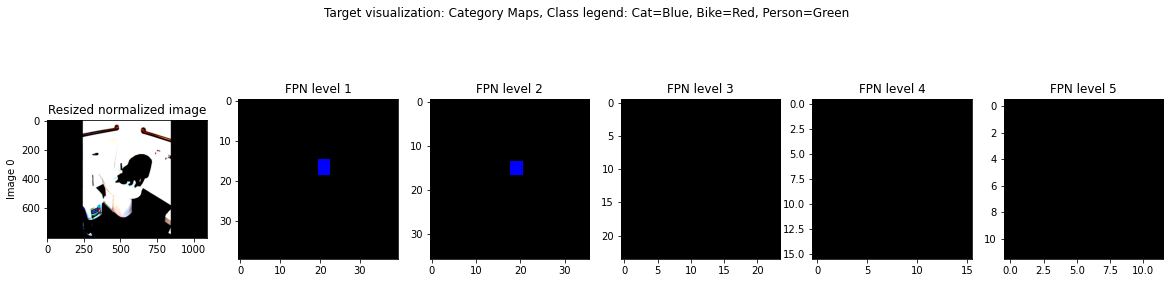

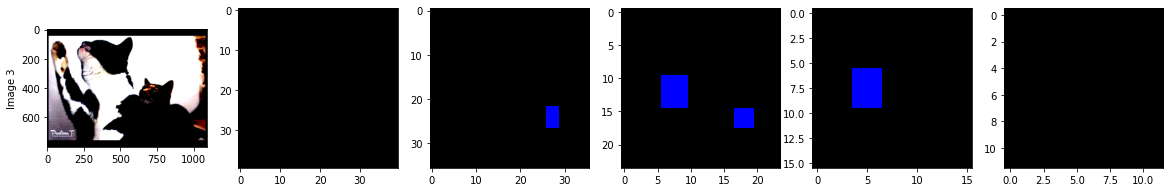

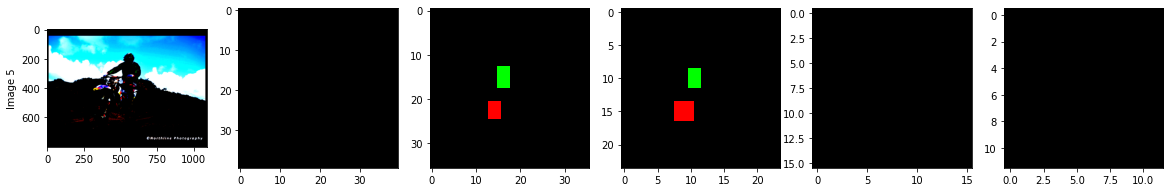

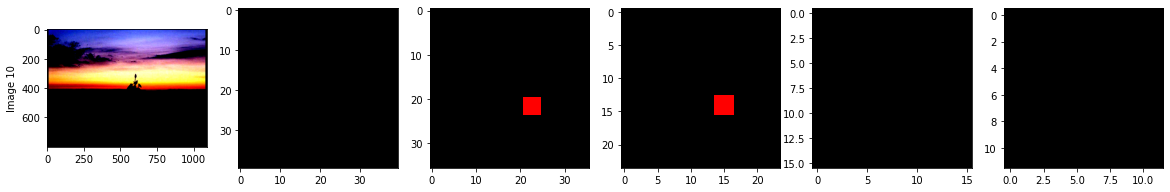

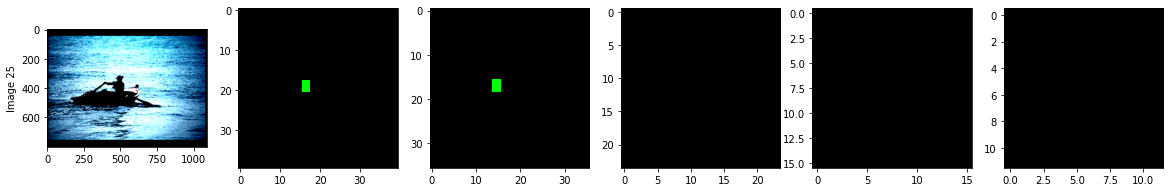

In [ ]:
# RUN THIS CELL TO VISUALIZE PREPROCESSED TARGET CATEGORY GRID MAPS BY FPN LEVEL
import logging

logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

model = SOLO()
im = []
l = []
m = []
b = []
for label_idx in [0, 3, 5, 10, 25]:
  im_example, l_example, m_example, b_example = train_dataset.__getitem__(label_idx)
  im.append(im_example)
  l.append(l_example)
  m.append(m_example)
  b.append(b_example)

ct, mt, am, al = model.generate_targets(b, l, m)

def plot_category_map(category_map):
  c = np.zeros((category_map.shape[0], category_map.shape[1], 3))
  for clss in (1, 2, 3):
    idx1, idx2 = np.nonzero(category_map == clss)
    c[idx1, idx2, clss-1] = 1
  return c

for i, label_idx in enumerate([0, 3, 5, 10, 25]):
  fig = plt.figure(figsize=(20, 5))
  if i == 0:
    plt.suptitle("Target visualization: Category Maps, Class legend: Cat=Blue, Bike=Red, Person=Green")
  ax = fig.add_subplot(1, 6, 1)
  img = np.transpose(im[i].numpy(), axes=(1, 2, 0))
  ax.imshow(img)
  ax.set_ylabel("Image " + str(label_idx))
  if i == 0:
    ax.set_title("Resized normalized image")
  ax = fig.add_subplot(1, 6, 2)
  category_map = ct[i][0].cpu().numpy() if al[i][0] else np.zeros((model.num_grids[0], model.num_grids[0]))
  ax.imshow(plot_category_map(category_map))
  if i == 0:
    ax.set_title("FPN level 1")
  ax = fig.add_subplot(1, 6, 3)
  category_map = ct[i][1].cpu().numpy() if al[i][1] else np.zeros((model.num_grids[1], model.num_grids[1]))
  ax.imshow(plot_category_map(category_map))
  if i == 0:
    ax.set_title("FPN level 2")
  ax = fig.add_subplot(1, 6, 4)
  category_map = ct[i][2].cpu().numpy() if al[i][2] else np.zeros((model.num_grids[2], model.num_grids[2]))
  ax.imshow(plot_category_map(category_map))
  if i == 0:
    ax.set_title("FPN level 3")
  ax = fig.add_subplot(1, 6, 5)
  category_map = ct[i][3].cpu().numpy() if al[i][3] else np.zeros((model.num_grids[3], model.num_grids[3]))
  ax.imshow(plot_category_map(category_map))
  if i == 0:
    ax.set_title("FPN level 4")
  ax = fig.add_subplot(1, 6, 6)
  category_map = ct[i][4].cpu().numpy() if al[i][4] else np.zeros((model.num_grids[4], model.num_grids[4]))
  ax.imshow(plot_category_map(category_map))
  if i == 0:
    ax.set_title("FPN level 5")

logger.setLevel(old_level)
plt.show()
del im, l, m, b, ct, mt, am, al, category_map, img, model, im_example, l_example, m_example, b_example

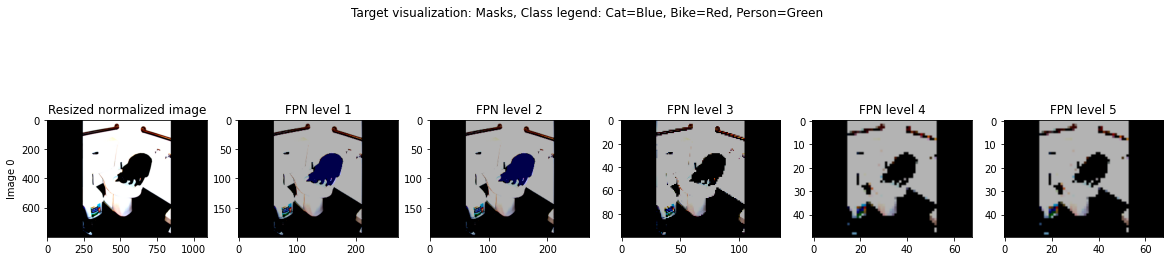

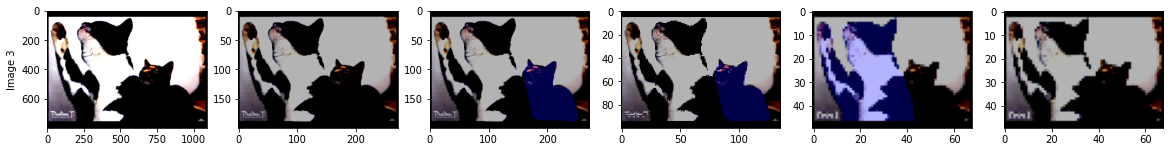

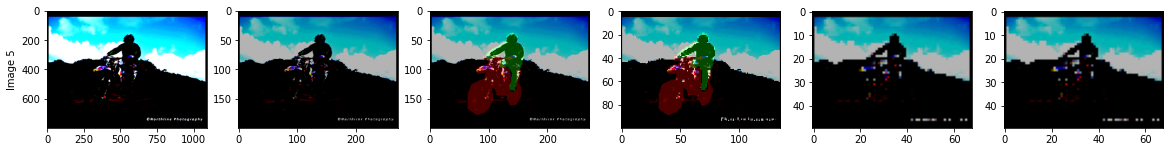

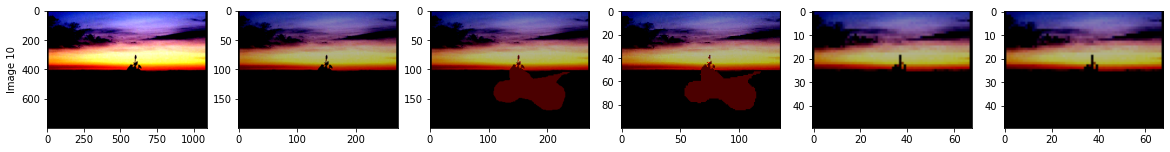

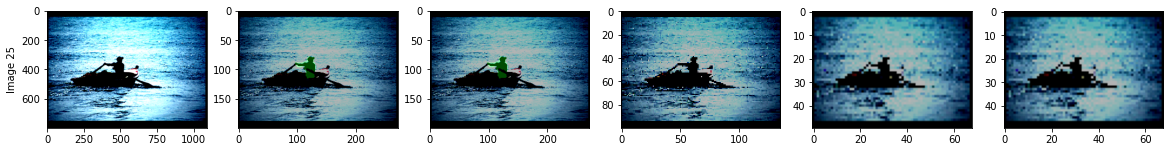

In [ ]:
# RUN THIS CELL TO VISUALIZE PREPROCESSED TARGET MASKS BY FPN LEVEL
model = SOLO()
im = []
l = []
m = []
b = []
for label_idx in [0, 3, 5, 10, 25]:
  im_example, l_example, m_example, b_example = train_dataset.__getitem__(label_idx)
  im.append(im_example)
  l.append(l_example)
  m.append(m_example)
  b.append(b_example)

ct, mt, am, al = model.generate_targets(b, l, m)

def resize_img(img, i):
  scales = [4, 4, 8, 16, 16]
  h = int(800 / scales[i])
  w = int(1088 / scales[i])
  resize_transform = transforms.Resize(size=(h, w))
  img_resized = resize_transform(img)
  return img_resized

def plot_mask(mask, category_map):
  flattened = category_map.reshape(-1)
  idx = np.nonzero(flattened)[0]
  mask_to_display = np.zeros((mask.shape[1], mask.shape[2], 3))
  for i in idx:
    clss = int(flattened[i])
    mask_to_display[:,:,clss-1] = mask[i,:,:]
  return mask_to_display

logger.setLevel(100)
for i, label_idx in enumerate([0, 3, 5, 10, 25]):
  fig = plt.figure(figsize=(20, 5))
  ax = fig.add_subplot(1, 6, 1)
  img = np.transpose(im[i].numpy(), axes=(1, 2, 0))
  ax.imshow(img)
  if i == 0:
    ax.set_title("Resized normalized image")
  ax.set_ylabel("Image " + str(label_idx))
  if i == 0:
    plt.suptitle("Target visualization: Masks, Class legend: Cat=Blue, Bike=Red, Person=Green")
  ax = fig.add_subplot(1, 6, 2)
  mask = mt[i][0].cpu().numpy() if al[i][0] else np.zeros((model.num_grids[0]**2, int(2*800/model.strides[0]), int(2*1088/model.strides[0])))
  category_map = ct[i][0].cpu().numpy() if al[i][0] else np.zeros((model.num_grids[0], model.num_grids[0]))
  img = np.transpose(resize_img(im[i], 0).numpy(), axes=(1, 2, 0))
  ax.imshow(img)
  ax.imshow(plot_mask(mask, category_map), alpha=0.3)
  if i == 0:
    ax.set_title("FPN level 1")
  ax = fig.add_subplot(1, 6, 3)
  mask = mt[i][1].cpu().numpy() if al[i][1] else np.zeros((model.num_grids[1]**2, int(2*800/model.strides[1]), int(2*1088/model.strides[1])))
  category_map = ct[i][1].cpu().numpy() if al[i][1] else np.zeros((model.num_grids[1], model.num_grids[1]))
  img = np.transpose(resize_img(im[i], 1).numpy(), axes=(1, 2, 0))
  ax.imshow(img)
  ax.imshow(plot_mask(mask, category_map), alpha=0.3)
  if i == 0:
    ax.set_title("FPN level 2")
  ax = fig.add_subplot(1, 6, 4)
  mask = mt[i][2].cpu().numpy() if al[i][2] else np.zeros((model.num_grids[2]**2, int(2*800/model.strides[2]), int(2*1088/model.strides[2])))
  category_map = ct[i][2].cpu().numpy() if al[i][2] else np.zeros((model.num_grids[2], model.num_grids[2]))
  img = np.transpose(resize_img(im[i], 2).numpy(), axes=(1, 2, 0))
  ax.imshow(img)
  ax.imshow(plot_mask(mask, category_map), alpha=0.3)
  if i == 0:
    ax.set_title("FPN level 3")
  ax = fig.add_subplot(1, 6, 5)
  mask = mt[i][3].cpu().numpy() if al[i][3] else np.zeros((model.num_grids[3]**2, int(2*800/model.strides[3]), int(2*1088/model.strides[3])))
  category_map = ct[i][3].cpu().numpy() if al[i][3] else np.zeros((model.num_grids[3], model.num_grids[3]))
  img = np.transpose(resize_img(im[i], 3).numpy(), axes=(1, 2, 0))
  ax.imshow(img)
  ax.imshow(plot_mask(mask, category_map), alpha=0.3)
  if i == 0:
    ax.set_title("FPN level 4")
  ax = fig.add_subplot(1, 6, 6)
  category_map = ct[i][4].cpu().numpy() if al[i][4] else np.zeros((model.num_grids[4], model.num_grids[4]))
  mask = mt[i][4].cpu().numpy() if al[i][4] else np.zeros((model.num_grids[4]**2, int(2*800/model.strides[4]), int(2*1088/model.strides[4])))
  img = np.transpose(resize_img(im[i], 4).numpy(), axes=(1, 2, 0))
  ax.imshow(img)
  ax.imshow(plot_mask(mask, category_map), alpha=0.3)
  if i == 0:
    ax.set_title("FPN level 5")
    
plt.show()
logger.setLevel(old_level)
del im, l, m, b, ct, mt, am, category_map, mask, img, model, im_example, l_example, m_example, b_example

### Part A Submission

NOTE: cells to run for visualization are specified in comments at the top of the cells

## Part B
### Loss
The loss function consists of two parts: category loss and mask loss:
$$L = \lambda_\text{cate} L_\text{cate} + \lambda_\text{mask} L_\text{mask} $$

The category loss is defined as (where $\text{FL}$ is the focal loss)

$$L_\text{cate} = \frac{1}{S^2 C} \sum_{S,S,C} \text{FL}(p_t)$$

$$\text{FL}(p_t) = -\alpha_t (1 - p_t)^\gamma \log{(p_t)}$$

$$(\alpha_t, p_t) = \left\{\begin{array}{lr} (\alpha, \hat{p}) & \text{if }y=1 \\ (1 - \alpha, 1 - \hat{p}) & \text{otherwise}\end{array}\right.$$

while the mask loss is defined as (where $d_\text{mask}$ is the dice loss)

$$L_\text{mask} = \frac{1}{N_\text{positive}} \sum_k \mathbb{1}_{\{p_{i, j} > 0\}} d_\text{mask}(m_k, \hat{m}_k)$$

$$d_\text{mask}(p, q) = 1 - D(p, q)$$

$$D(p, q) = \frac{2 \sum_{x,y}(p_{x,y} \cdot q_{x,y})}{\sum_{x,y}p_{x,y}^2 + \sum_{x,y}q_{x,y}^2}$$

### Post Processing
Post processing consists of three steps: points NMS, concatenation and sorting, and matrix NMS. A summary of each of these steps is provided below. In addition, your final mask prediction should be a binary mask based on the mask thresholding parameter. Some examples of results post-inference are shown in figs. 11-14.


<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig11.png" width=300/></div>
<center>Figure 11: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig12.png" width=300/></div>
<center>Figure 12: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig13.png" width=300/></div>
<center>Figure 13: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig14.png" width=300/></div>
<center>Figure 14: SOLO instance segmentation example.</center>

#### Points NMS
Non-max suppression for the category predictions, applied to each channel sperately. A maxpooling with a kernel size of 2, sample code is included below.

#### Concatenation and Sorting
Here, we merge the predictions across all the FPN levels into a single list of predictions, sorted by their predicted score. This involves rescaling the predicted masks appropriately.

#### Matrix NMS
Inspired by Soft-NMS, MatrixNMS suppresses mask predictions with a lower score based on their similarity to predictions with a higher score in a completely vectorized manner. Sample code is include below.

### Training
#### Optimizer
The SGD optimizer with a weight decay of 1e-4 and a momentum of 0.9 is used. For a batch size of 16, an initial learning rate of 16 is used (this should be scaled appropriately for different batch sizes). You should train for 36 epochs, reducing the learning rate by a factor of 10 at epochs 27 and 33.

#### Data Augemnetation
To achieve better performance, you may wish to explore some data augmentation techniques. You should be able to achieve the necessary performance without any augmentation, however.

#### Checkpointing
Due to the long training time, we highly recommend that you set up regular checkpointing during your training in case your training gets interrupted (e.g. your colab session ending).

In [ ]:
# Setting up training
import math
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint

num_epochs = 36

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints/",
    filename="solo-{epoch:02d}-{val_loss:.2f}",
    save_top_k=num_epochs,
    mode="min",
)

train_loader = DataLoader(train_dataset, batch_size=4, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, collate_fn=collate_fn)



/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory checkpoints/ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


In [ ]:

model = SOLO()
trainer = pl.Trainer(max_epochs=num_epochs, gpus=1, callbacks=[checkpoint_callback], num_sanity_val_steps=0)
trainer.fit(model, train_loader, val_loader)
torch.save(model.state_dict(), 'solo.pth')
np.save('train_losses.npy', model.train_losses)
np.save('val_losses.npy', model.val_losses)

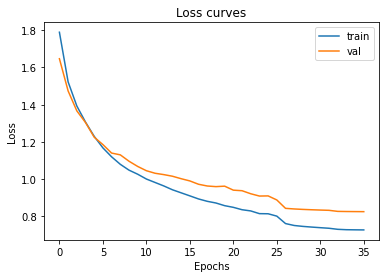

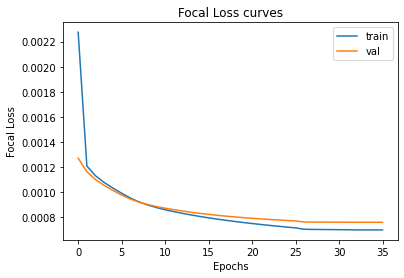

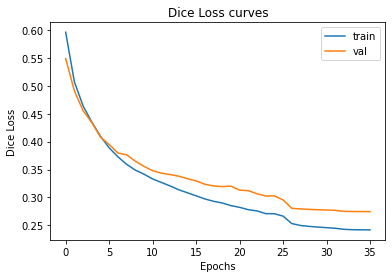

In [9]:
# RUN THIS CELL TO VISUALIZE LOSSES OVER TRAINING
import matplotlib.pyplot as plt

train_losses = np.load("train_losses.npy")
val_losses = np.load("val_losses.npy")

plt.figure()
epochs = np.arange(36)
plt.plot(epochs, [l[0] for l in train_losses])
plt.plot(epochs, [l[0] for l in val_losses])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss curves')

plt.legend(['train', 'val']) 

plt.figure()
plt.plot(epochs, [l[1] for l in train_losses])
plt.plot(epochs, [l[1] for l in val_losses])
plt.xlabel('Epochs')
plt.ylabel('Focal Loss')
plt.title('Focal Loss curves')

plt.legend(['train', 'val']) 

plt.figure()
plt.plot(epochs, [l[2] for l in train_losses])
plt.plot(epochs, [l[2] for l in val_losses])
plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.title('Dice Loss curves')

plt.legend(['train', 'val']) 
plt.show()


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


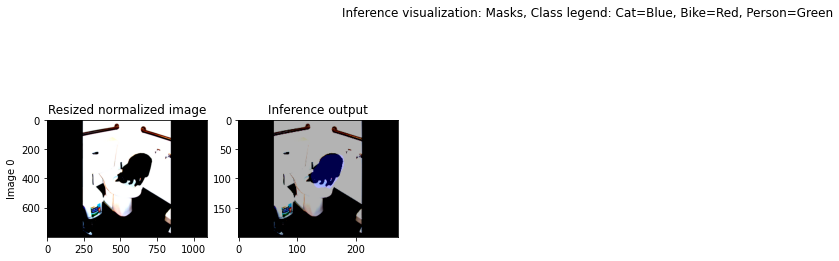

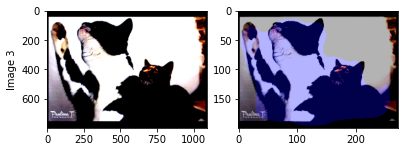

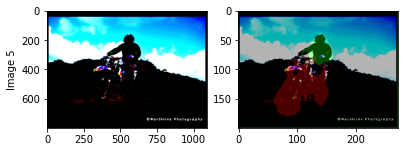

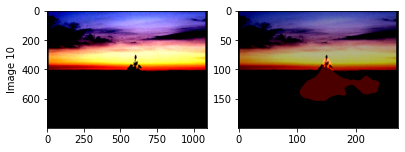

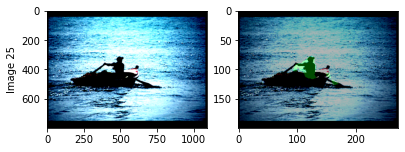

In [10]:
# RUN THIS CELL TO VISUALIZE INFERENCE OUTPUTS BY FPN LEVEL
import logging

logger = logging.getLogger()
old_level = logger.level
model = SOLO().to(device)
model.eval().load_state_dict(torch.load('solo.pth', map_location='cpu'))
im = []
for label_idx in [0, 3, 5, 10, 25]:
  im_example, _, _, _ = train_dataset.__getitem__(label_idx)
  im.append(im_example)

def resize_img(img, i):
  h = int(800 / 4)
  w = int(1088 / 4)
  resize_transform = transforms.Resize(size=(h, w))
  img_resized = resize_transform(img)
  return img_resized

def plot_inference_output(categories, masks):
  h = int(800 / 4)
  w = int(1088 / 4)
  mask_to_display = np.zeros((h, w, 3))
  for i in range(len(categories)):
    clss = categories[i]
    mask_to_display[:,:,clss] = masks[i,:,:]
  return mask_to_display

logger.setLevel(100)
for i, label_idx in enumerate([0, 3, 5, 10, 25]):
  fig = plt.figure(figsize=(20, 5))
  ax = fig.add_subplot(1, 6, 1)
  img = np.transpose(im[i].numpy(), axes=(1, 2, 0))
  ax.imshow(img)
  if i == 0:
    ax.set_title("Resized normalized image")
  ax.set_ylabel("Image " + str(label_idx))
  if i == 0:
    plt.suptitle("Inference visualization: Masks, Class legend: Cat=Blue, Bike=Red, Person=Green")
  ax = fig.add_subplot(1, 6, 2)
  categories, masks = model.inference(im[i])
  masks = masks.cpu().numpy()
  categories = categories.cpu().numpy()
  mask_to_display = plot_inference_output(categories, masks)
  img = np.transpose(resize_img(im[i], 0).numpy(), axes=(1, 2, 0))
  ax.imshow(img)
  ax.imshow(mask_to_display, alpha=0.3)
  if i == 0:
    ax.set_title("Inference output")
    
plt.show()
logger.setLevel(old_level)
del im, categories, masks, img, mask_to_display

## Discussion

####Resource Usage 
One of the primary issues we encountered with this project was that the training time was very long, this meant that our code needed to be as optimized as possible to obtain iterative results to improve our network in a timely manner. This problem took up the bulk of our time working on the project.  Originally our training took over 30 hours which meant that we could not train on colab, we also could not train on our personal computers as the VRAM usage was over 10 Gb, more than available on a most consumer GPUs. We ended up needing to use an enterprise lab network at penn for our first training. We also encountered multiple colab crashes due to RAM limitations.
We were able to both cut down on the training time and reduce our RAM usage by reducing our batch size to 4. We also noted that only the FPN levels corresponding to positive targets are necessary to store, so we replaced the other levels with “None” values to indicate that there are no ground truth instances on that level. This prevented moving unnecessary large tensors onto the GPU and cut down our training time. It also prevented us from using all available RAM. 

####Post Processing 
For the most part, we did not change the post-processing methods or suggested hyperparameter values. However, we did change the final mask selection procedure at the very end of inference, after NMS. Instead of picking the 5 masks with the largest scores after NMS, we picked the masks with scores above a threshold of 0.2 after NMS. We found that this procedure significantly cut down on false detections.

####Architecture and Training
Due to the small batch size, we adjusted the initial learning rate to be 0.025 instead of 0.01 to prevent large updates to the weights for smaller batch sizes, which could prevent convergence of the loss during training. Other than the batch size and learning rate, we did not make any changes to the model architecture or training hyperparameters because it is clear from the loss plots that the differences between training and validation loss are trivial, so the model neither underfits nor overfits. The inference visualization suggests correct classification and reasonable segmentation performance, so we can conclude that our model performs reasonably well.

####Next Steps
Although our model performs reasonably well, there are several avenues for future improvement. First, we would hope to incorporate multi-GPU training to increase the batch size to 16. This would allow us to decrease our learning rate and speed up loss convergence during training. Second, although we were unable to accomplish this due to the limited available resources we had, if we had more time and resources, we would train the model for more epochs and observe when the mask loss converges to determine the optimal number of epochs. We would also experiment with which epochs to decrease the learning rate in.



### Part B Submission
In addition to the code you used, you should submit a pdf containing the following plots:
* Dataset visualization plots such as fig. 5 and 6. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Target assignment plots such as fig. 8 and 9. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Final inference results such as figs. 11-14. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Training and validation loss curves. These should include the focal loss, dice loss, and total loss as seperate quantities.

We should be able to reproduce your results with a single function call or cell evaluation. Please specify the method to do so. You do not, however, need to submit your trained weights.

In addition, you should include a discussion of any issues you encountered during this project and any changes you made to the siggested architecture. If you made any interesting observations or thoughts about potential improvements, you should also include them here.

There will likely be a performance benchmark for this project - more details to be announced.